In [18]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import os
import tensorflow as tf

In [19]:
import zipfile

data_r = zipfile.ZipFile('train.zip', 'r')
data_r.extractall()

In [20]:
data_r = zipfile.ZipFile('test.zip', 'r')
data_r.extractall()

In [21]:
def download_data(path):
  data = []
  for path_image in sorted(os.listdir(path=path)):
    image = Image.open(path + path_image) #Открываем изображение.
    data.append(np.array(image)) #Загружаем пиксели.
  return data

In [22]:
X_train = download_data(r"train/images/")
Y_train = download_data(r"train/masks/")
X_test = download_data(r"test/images/")
Y_test = download_data(r"test/masks/")


In [23]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask

In [24]:
X_train, Y_train = resize(X_train, Y_train)

In [25]:
X_test, Y_test = resize(X_test, Y_test)

In [26]:
X_train[0]

<tf.Tensor: shape=(128, 128, 3), dtype=int32, numpy=
array([[[238, 241, 246],
        [185, 190, 196],
        [249, 255, 255],
        ...,
        [178, 177, 185],
        [220, 219, 225],
        [235, 237, 250]],

       [[254, 255, 255],
        [252, 255, 255],
        [250, 251, 253],
        ...,
        [213, 209, 223],
        [199, 192, 199],
        [152, 145, 152]],

       [[194, 194, 196],
        [239, 238, 243],
        [253, 254, 255],
        ...,
        [ 96,  88, 101],
        [157, 142, 149],
        [148, 132, 133]],

       ...,

       [[213, 207, 217],
        [238, 233, 239],
        [211, 208, 219],
        ...,
        [247, 240, 234],
        [218, 211, 203],
        [241, 234, 224]],

       [[231, 225, 235],
        [166, 161, 167],
        [211, 208, 219],
        ...,
        [255, 253, 250],
        [237, 230, 222],
        [223, 216, 208]],

       [[246, 240, 250],
        [198, 191, 198],
        [199, 197, 208],
        ...,
        [240, 237, 23

In [27]:
len(Y_train)

7

In [28]:
len(Y_train[0])

128

In [29]:
len(Y_train[0][0])

128

In [30]:
Y_train[0][0][0]

<tf.Tensor: shape=(4,), dtype=int32, numpy=array([132,  41, 246, 255])>

In [31]:
len(Y_train[0][0][0])

4

In [32]:
palette = {0 : (60, 16, 152), # Building
           1 : (132, 41, 246), # Land
           2 : (110, 193, 228), # Road
           3 : (254, 221, 58), # Vegetation
           4 : (226, 169, 41), # Water
           5 : (155, 155, 155)} # Unlabeled

In [33]:
invert_palette = {v: k for k, v in palette.items()}

In [34]:
# сегментация нейронной сети в RGB изображение
def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

In [35]:
def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.int8) # принадлежность каждого пикселя классу
    min_distance = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.float32)+1000 # расстояние до ближайшего класса для пикселей
    for c, i in palette.items():
      distance = np.sum((arr_3d - np.array(c).reshape(1, 1, 3))**2, axis=-1)**(1/2) # ищем расстояние для каждого пикселя до проверяемого класса по евклиду рас-ие
      condition = min_distance > distance # поиск элементов меньше min_distance
      min_distance[condition] = distance[condition] # замена дистанции найденных элементов
      arr_2d[condition] = i # замена класса найденных элементов

    for c, i in palette.items():
      m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
      arr_2d[m] = i

    arr_2d = arr_2d.tolist()
    for i in range(len(arr_2d)):
      for j in range(len(arr_2d[0])):
        label = [0, 0, 0, 0, 0, 0]
        label[arr_2d[i][j]] = 1
        arr_2d[i][j] = label
    arr_2d = np.array(arr_2d)

    return arr_2d

In [36]:
X_train_pred = np.array(X_train).reshape([7, 128, 128, 3])/255
X_test_pred = np.array(X_test).reshape([2, 128, 128, 3])/255
Y_train_pred = []
for i in range(len(Y_train)):
  Y_train_pred.append(convert_from_color(Y_train[i][:, :, :3]))
Y_train_pred = np.array(Y_train_pred)
Y_test_pred = []
for i in range(len(Y_test)):
  Y_test_pred.append(convert_from_color(Y_test[i][:, :, :3]))
Y_test_pred = np.array(Y_test_pred)


In [37]:
import numpy as np
from keras import *
from keras.models import *
from keras.layers import *
from keras.optimizers import *

In [38]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

In [39]:
def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

In [40]:
def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

In [41]:
def build_unet_model():
   # inputs
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(6, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [42]:
unet_model = build_unet_model()

In [43]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss="categorical_crossentropy",
                  metrics="accuracy")

In [44]:
%%time

history = unet_model.fit(X_train_pred, Y_train_pred,  epochs=10, validation_data = (X_test_pred, Y_test_pred))

Epoch 1/10
1/1 [==============================] - 11s 11s/step - loss: 2.5389 - accuracy: 0.0652 - val_loss: 1.1302 - val_accuracy: 0.6051
Epoch 2/10
1/1 [==============================] - 5s 5s/step - loss: 1.3060 - accuracy: 0.6264 - val_loss: 1.0865 - val_accuracy: 0.6051
Epoch 3/10
1/1 [==============================] - 5s 5s/step - loss: 1.1261 - accuracy: 0.6264 - val_loss: 1.0087 - val_accuracy: 0.6051
Epoch 4/10
1/1 [==============================] - 6s 6s/step - loss: 1.0646 - accuracy: 0.6269 - val_loss: 1.0063 - val_accuracy: 0.6051
Epoch 5/10
1/1 [==============================] - 5s 5s/step - loss: 1.0563 - accuracy: 0.6269 - val_loss: 1.0086 - val_accuracy: 0.6051
Epoch 6/10
1/1 [==============================] - 5s 5s/step - loss: 1.0395 - accuracy: 0.6283 - val_loss: 1.0052 - val_accuracy: 0.6055
Epoch 7/10
1/1 [==============================] - 5s 5s/step - loss: 1.0216 - accuracy: 0.6319 - val_loss: 1.0160 - val_accuracy: 0.6055
Epoch 8/10
1/1 [=======================

In [50]:
out = unet_model.predict(X_test_pred[:2], batch_size=1)

2/2 [==============================] - 1s 140ms/step


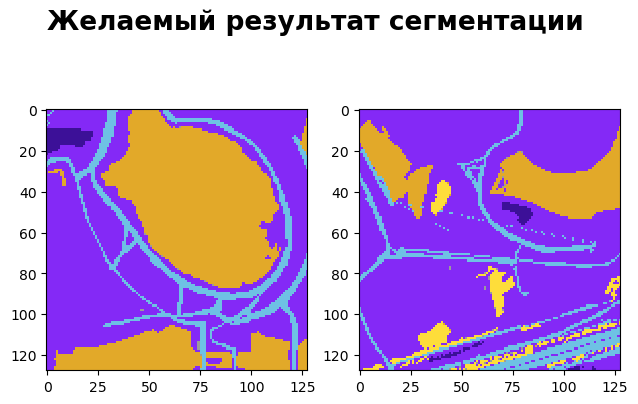

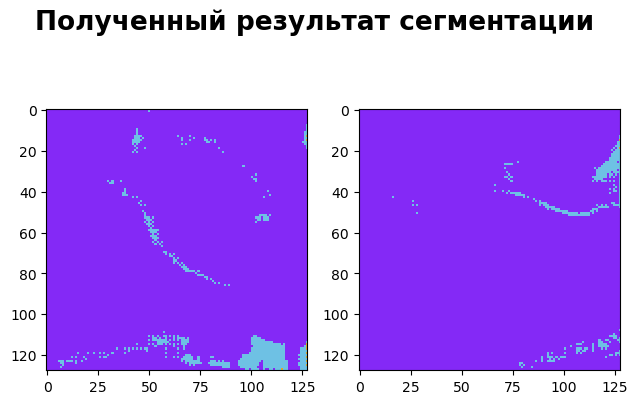

In [51]:
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(Y_test_pred[i], axis=-1)))
plt.suptitle('Желаемый результат сегментации', fontsize=19, fontweight='bold')
plt.tight_layout()
plt.show()

# Выведем 2-е картинки полученые методом predict
for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.imshow(convert_to_color(np.argmax(out[i], axis=-1)))
plt.suptitle('Полученный результат сегментации', fontsize=19, fontweight='bold')
plt.tight_layout()
plt.show()